In [4]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import sqlite3
import joblib

In [5]:
# URL
url = 'https://eu.wikipedia.org/wiki/Berria'

# solicitud HTTP
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Localizar el contenido principal del artículo que queremos utilizar
contenido_articulo = soup.find('div', {'id': 'bodyContent'})  

# Si encontramos el contenido, extraemos el texto
palabras = []
if contenido_articulo:
    texto = contenido_articulo.get_text() 
    palabras.extend(texto.split())  # Dividir los textos en palabras

# Filtramos los duplicados
palabras = list(set(palabras))

# Mostramos algunas palabras
print(palabras[:10])

# Guardamos las palabras en un CSV
df_euskara_1 = pd.DataFrame(palabras, columns=['palabra'])
df_euskara_1["idioma"] = "euskara"  
df_euskara_1.to_csv("palabras_euskara_uno.csv", index=False)

['sakelako', 'errentagarri', 'euro', 'agortu', 'Egunkariarekin', 'jabe', 'bikaina', 'eskualdetan', 'Larunbatetan:', 'Horren']


In [6]:
# URL 
url = "https://eu.wikipedia.org/wiki/Euskal_Herriko_historia"

# solicitud HTTP
response = requests.get(url)

# Verificamos que la solicitud es ok
if response.status_code == 200:
    # Parseamos el contenido HTML de la web
    soup = BeautifulSoup(response.text, 'html.parser')

    # Buscamos todos los párrafos
    paragraphs = soup.find_all('p')

    # guardamos todas las palabras extraidas en una lista
    palabras_euskara = []

    # Sacamos las palabras de cada párrafo
    for paragraph in paragraphs:
        text = paragraph.get_text(strip=True)

        # Dividir el texto en palabras
        words = text.split()

        # Filtramos las palabras que solo contienen letras
        for word in words:
            if word.isalpha(): 
                palabras_euskara.append(word.lower())  # Convertimos a minúsculas 

    # DataFrame con las palabras extraídas
    df_euskara_2 = pd.DataFrame(palabras_euskara, columns=["palabra"])
    df_euskara_2["idioma"] = "euskara" 

    # Mostramos algunas palabras
    print(palabras[:10])

    # Guardamos las palabras en un CSV
    df_euskara_2.to_csv("palabras_euskera_dos.csv", index=False)
else:
    print(f"Error: {response.status_code}")


['sakelako', 'errentagarri', 'euro', 'agortu', 'Egunkariarekin', 'jabe', 'bikaina', 'eskualdetan', 'Larunbatetan:', 'Horren']


In [7]:
# URL
url = "https://eu.wikipedia.org/wiki/Euskal_Herria"

# solicitud HTTP
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# Extraemos el texto
contenido = soup.find("div", class_="mw-page-container-inner")

# solo palabras
palabras_2 = contenido.get_text(separator=' ').split()

# Mostamos algunas palabras
print(palabras_2[:5])

# Dataframe
df_euskara_3 = pd.DataFrame(palabras_2, columns=["palabra"])
df_euskara_3["idioma"] = "euskara"  

# Guardamos el DataFrame como CSV
df_euskara_3.to_csv("palabras_euskera_tres.csv", index=False)


['Edukiak', 'mugitu', 'alboko', 'barrara', 'ezkutatu']


In [8]:
# Combinar los tres DataFrames en uno solo
df_completo = pd.concat([df_euskara_1, df_euskara_2,df_euskara_3], ignore_index=True)

# Guardamos el DataFrame 
df_completo.to_csv("palabras_euskera_completo.csv", index=False)

df_completo.head()

,palabra,idioma
0,sakelako,euskara
1,errentagarri,euskara
2,euro,euskara
3,agortu,euskara
4,Egunkariarekin,euskara


In [9]:
# Cargamos archivo csv Euskara
euskara_df = pd.read_csv("/Users/patri/Desktop/DS24/ONLINE_DS_THEBRIDGE_PGF/PROJECT_BREAK_ML/palabras_euskera_completo.csv")

# Cargamos archivo txt Castellano y convertimos en DataFrame
with open("/Users/patri/Desktop/DS24/ONLINE_DS_THEBRIDGE_PGF/PROJECT_BREAK_ML/0_palabras_todas.txt", 'r', encoding='utf-8') as file:
    castellano_words = file.read().splitlines()
    
castellano_df = pd.DataFrame(castellano_words, columns=["palabra"])

# Añadir la columna de idioma
euskara_df["idioma"] = "euskara"
castellano_df["idioma"] = "castellano"

# Unir los dos DataFrames
df = pd.concat([euskara_df, castellano_df], ignore_index=True)

df.head(10)


,palabra,idioma
0,sakelako,euskara
1,errentagarri,euskara
2,euro,euskara
3,agortu,euskara
4,Egunkariarekin,euskara
5,jabe,euskara
6,bikaina,euskara
7,eskualdetan,euskara
8,Larunbatetan:,euskara
9,Horren,euskara


In [10]:
df["idioma"].value_counts()

idioma
castellano    647161
euskara        26635
Name: count, dtype: int64

In [11]:
#el dataset esta muy desbalanceado, lo ajustamos.

# tamaño actual de las clases
print(f"Antes de ajustar el tamaño de castellano:")
print(df["idioma"].value_counts())

# Calculamos el valuecounts de la clase euskara
euskara_count = df["idioma"].value_counts()["euskara"]

# Ajustamos la clase castellano por el doble del euskara
castellano_count = euskara_count * 2 

# Filtramos las palabras de castellano y ajustarlas
castellano_df_adjusted = castellano_df.sample(n=castellano_count, random_state=42)

# juntamos los DataFrames ajustados
df= pd.concat([euskara_df, castellano_df_adjusted], ignore_index=True)

# tamaño de las clases después del ajuste
print(f"\nDespués de ajustar el tamaño de castellano:")
print(df['idioma'].value_counts())

Antes de ajustar el tamaño de castellano:
idioma
castellano    647161
euskara        26635
Name: count, dtype: int64

Después de ajustar el tamaño de castellano:
idioma
castellano    53270
euskara       26635
Name: count, dtype: int64


In [12]:
df["palabra"].head(10) #vemos signos al final y al principio de las palabras

0          sakelako
1      errentagarri
2              euro
3            agortu
4    Egunkariarekin
5              jabe
6           bikaina
7       eskualdetan
8     Larunbatetan:
9            Horren
Name: palabra, dtype: object

In [13]:
#hacemos una copia del Df
df = df.copy()

# Funciónn de limpieza
def limpiar_palabra(palabra):
    if isinstance(palabra, str):
        return re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ]', '', palabra)
    return ''

# Función de división (hay palabras en euskara juntas que son en realidad 1 y se distinguen por la mayuscula que hay en medio)
def dividir_por_mayusculas(palabra):
    if isinstance(palabra, str):
        return re.findall(r'[A-ZÁÉÍÓÚÑ][a-záéíóúñ]+|[a-záéíóúñ]+', palabra)
    return []


# LIMPIEZA

# Paso 1: limpieza de caracteres no alfabéticos
df["palabra"] = df["palabra"].apply(limpiar_palabra)

# Paso 2: división por mayúsculas
df["palabra_lista"] = df["palabra"].apply(dividir_por_mayusculas)

# Paso 3: transformamos la palabra conjunta en dos o X palabras y creamos otra fila
df = df.explode("palabra_lista") 

# Paso 4: reasignamos palabra buena
df["palabra"] = df["palabra_lista"]
df = df.drop(columns=["palabra_lista"])

# Paso 5: generamos un nuevo índice
df.reset_index(drop=True, inplace=True)

# Paso 6: solo letras al principio
filtro_valido = df["palabra"].apply(lambda x: isinstance(x, str) and re.match(r'^[a-zA-ZáéíóúÁÉÍÓÚñÑ]', x) is not None)
df = df.loc[filtro_valido].copy()

# Paso 7: convertimos todas las palabras a minúsculas
df["palabra"] = df["palabra"].str.lower()


df


,palabra,idioma
0,sakelako,euskara
1,errentagarri,euskara
2,euro,euskara
3,agortu,euskara
4,egunkariarekin,euskara
...,...,...
80063,reconcilió,castellano
80064,permutasen,castellano
80065,entrecierres,castellano
80066,desfibrarían,castellano


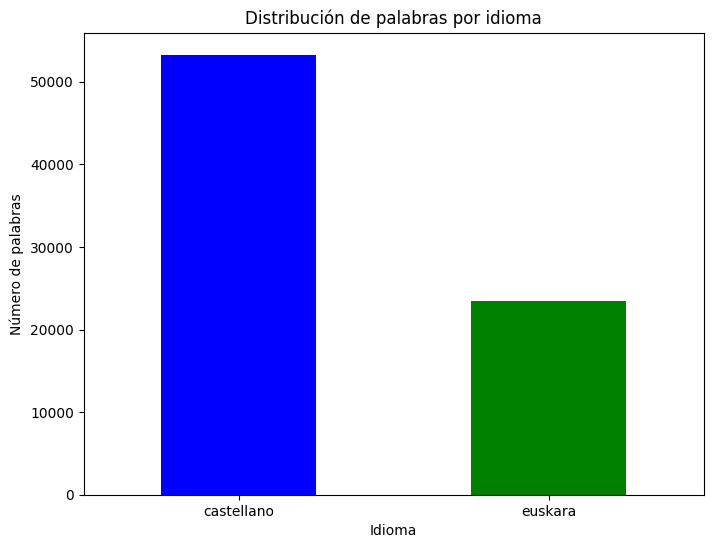

Distribución de las clases:
idioma
castellano    53270
euskara       23492
Name: count, dtype: int64


In [14]:
clase_distr = df["idioma"].value_counts()

# Visualización la distribución
plt.figure(figsize=(8, 6))
clase_distr.plot(kind="bar", color=["blue", "green"])
plt.title("Distribución de palabras por idioma")
plt.xlabel("Idioma")
plt.ylabel("Número de palabras")
plt.xticks(rotation=0)
plt.show();

print(f"Distribución de las clases:\n{clase_distr}")

In [15]:
# Ver el tamaño del dataset
print(f"Tamaño total del dataset: {len(df)}")

Tamaño total del dataset: 76762


In [16]:
# palabras más frecuentes en euskera
euskara_palabras = df[df["idioma"] == "euskera"]["palabra"].value_counts().head(10)
print("Palabras más frecuentes en Euskera:\n", euskara_palabras)

# palabras más frecuentes en castellano
castellano_palabras = df[df["idioma"] == "castellano"]["palabra"].value_counts().head(10)
print("Palabras más frecuentes en Castellano:\n", castellano_palabras)

Palabras más frecuentes en Euskera:
 Series([], Name: count, dtype: int64)
Palabras más frecuentes en Castellano:
 palabra
absorbéis           1
descristianizará    1
epatábamos          1
pintarrajasteis     1
apechásemos         1
lacandona           1
populariza          1
refringe            1
chuchearon          1
conformaste         1
Name: count, dtype: int64


In [17]:
# Vectorizamos las palabras usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  
X_vect = vectorizer.fit_transform(df["palabra"])

print(X_vect.shape)

(76762, 5000)


In [18]:
# Extraer las etiquetas (idioma)
y = df["idioma"]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.3, random_state=42)


In [19]:
# Codificamos las etiquetas mediante LabelEncoder #0 Castellano y 1 Euskara
label_encoder = LabelEncoder()
label_encoder.fit(["castellano", "euskara"]) 

LabelEncoder()

In [20]:
# Convertimos las etiquetas en y_train y y_test a valores numéricos (0,1)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [21]:
# Entrenamos el modelo Random Forest con ajuste de pesos de clase
rf_model_weighted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model_weighted.fit(X_train, y_train_encoded)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [22]:
# Predecir y evaluamos el modelo
y_pred_weighted_encoded = rf_model_weighted.predict(X_test)

# Convertimos las predicciones de vuelta a las etiquetas originales
y_pred_weighted = label_encoder.inverse_transform(y_pred_weighted_encoded)

# Informe de clasificación
print(classification_report(y_test, y_pred_weighted))

              precision    recall  f1-score   support

  castellano       0.89      1.00      0.94     16103
     euskara       1.00      0.72      0.83      6926

    accuracy                           0.91     23029
   macro avg       0.94      0.86      0.89     23029
weighted avg       0.92      0.91      0.91     23029



In [23]:
# Conexión a la base de datos (se creará si no existe)
conn = sqlite3.connect("palabras_classified.db")
cursor = conn.cursor()

# Crear las tablas para euskara y castellano
cursor.execute('''
CREATE TABLE IF NOT EXISTS euskara (
    id INTEGER PRIMARY KEY,
    palabra TEXT UNIQUE,
    idioma TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS castellano (
    id INTEGER PRIMARY KEY,
    palabra TEXT UNIQUE,
    idioma TEXT
)
''')

# Confirmar que las tablas se crearon correctamente
conn.commit()

       

In [24]:
# Función de clasificación e inserción ajustada
def classify_and_insert(word, model, label_encoder, vectorizer):
    word_vectorized = vectorizer.transform([word]) # Vectorizar la palabra 

    # Predicción de la palabra
    prediction = model.predict(word_vectorized)  
    print(f"Predicción para '{word}': {prediction}")  

    # Convertir el resultado numérico a la etiqueta original (0 castellano y 1 euskara)
    pred_label = label_encoder.inverse_transform(prediction)[0]

    # Insertar la palabra en la tabla correspondiente
    if pred_label == 'euskara':
        cursor.execute(f'''
        INSERT OR IGNORE INTO euskara (palabra, idioma) 
        VALUES (?, ?)
        ''', (word, 'euskara'))
    elif pred_label == 'castellano':
        cursor.execute(f'''
        INSERT OR IGNORE INTO castellano (palabra, idioma) 
        VALUES (?, ?)
        ''', (word, 'castellano'))

    # Confirmar que los cambios se guardaron
    conn.commit()

# Ejemplo de uso:

# Verificamos las clases del LabelEncoder
print(f"Clases del LabelEncoder: {label_encoder.classes_}")

# Solicitamos al usuario que ingrese nuevas palabras, separadas por comas
input_words = input("Ingresa las palabras a clasificar, separadas por comas: ")

# Convertimos la entrada en una lista de palabras
new_words = input_words.split(',')

# Limpiamos las palabras eliminando espacios adicionales
new_words = [word.strip() for word in new_words]

# Clasificamos e insertarmos las palabras en las tablas correspondientes
for word in new_words:
    classify_and_insert(word, rf_model_weighted, label_encoder, vectorizer)

# ejemplo de las primeras 5 filas
cursor.execute("SELECT * FROM euskara LIMIT 5")
print("Euskara:", cursor.fetchall())

cursor.execute("SELECT * FROM castellano LIMIT 5")
print("Castellano:", cursor.fetchall())

# Cerrar la conexión
conn.close()


Clases del LabelEncoder: ['castellano' 'euskara']
Predicción para 'herria': [1]
Euskara: [(1, 'herria', 'euskara')]
Castellano: []


In [25]:
# Verificamos las palabras clasificadas en cada tabla
conn = sqlite3.connect("palabras_classified.db")
cursor = conn.cursor()

cursor.execute("SELECT * FROM euskara LIMIT 5")
print("Palabras en Euskara:", cursor.fetchall())

cursor.execute("SELECT * FROM castellano LIMIT 5")
print("Palabras en Castellano:", cursor.fetchall())

conn.close()

Palabras en Euskara: [(1, 'herria', 'euskara')]
Palabras en Castellano: []


In [27]:
# Guardamos el modelo entrenado
joblib.dump(vectorizer, "vectorizer.pkl") # para vectorizar nuevas palabras que ingrese el usuario
joblib.dump(rf_model_weighted, "ML project.pkl")

['ML project.pkl']